In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import os
import json
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch.optim as optim


competition = 'asl-signs'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

plt.style.use("ggplot")

In [3]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('..') / 'input'  / 'competition'
    # !pip install -Uqq fastai
else:
    import zipfile, kaggle
    path = Path.home() / '.data' / 'asl-signs'
    if not path.exists():
        path.mkdir(exist_ok=True)
        kaggle.api.competition_download_cli(competition, path=path)
        zipfile.ZipFile(path / f'{competition}.zip').extractall(path)

# Labeled Data

In [4]:
with open(path / 'sign_to_prediction_index_map.json') as f:
    sign_labels = json.load(f)

In [23]:
train = (pd.read_csv(path / 'train_with_meta.csv')
         .assign(idx=lambda x: x.participant_id.astype(str) + '_' + x.sequence_id.astype(str))
         .set_index('idx')
        )



signs_subset = ['TV', 'because', 'duck', 'balloon',
                'boy', 'fish',  'thankyou', 'underwear'
               ]
train = train.loc[train.sign.isin(signs_subset)]

sign_labels = {sign: i for i, sign in enumerate(signs_subset)}

train.head()

,path,participant_id,sequence_id,sign,cnt_partial_nulls,cnt_partial_nulls_by_frame,total_frames,face,left_hand,pose,right_hand
idx,,,,,,,,,,,
26734_1000241583,train_landmark_files/26734/1000241583.parquet,26734,1000241583,duck,0.0,0.0,30.0,30.0,0.0,30.0,30.0
61333_1001819372,train_landmark_files/61333/1001819372.parquet,61333,1001819372,balloon,0.0,0.0,27.0,27.0,16.0,27.0,0.0
61333_1002052130,train_landmark_files/61333/1002052130.parquet,61333,1002052130,TV,0.0,0.0,116.0,116.0,109.0,116.0,0.0
2044_1002091184,train_landmark_files/2044/1002091184.parquet,2044,1002091184,duck,0.0,0.0,18.0,18.0,0.0,18.0,18.0
22343_1003347075,train_landmark_files/22343/1003347075.parquet,22343,1003347075,TV,0.0,0.0,89.0,89.0,69.0,89.0,0.0


### Removing records with <=3 hand frames

In [24]:
(train.groupby(train.loc[:, ['left_hand', 'right_hand']].max(axis=1) <= 3)
 .size()
)

False    2806
True      264
dtype: int64

In [25]:
mask = train.loc[:, ['left_hand', 'right_hand']].max(axis=1) > 3
train = train.loc[mask, :]
train.shape

(2805, 11)

# Competition Data Loader

In [26]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

# Data Loader

In [27]:
class ASLRecord:
    POSE_LANDMARK_INDICES = [23, 11, 13, 15, 24, 12, 14, 16]
    def __init__(self, record_id):
        self.record_id = record_id
        self.record = train.loc[self.record_id, :]

        self.landmarks = pd.read_parquet(path / self.record['path'])
    
    @property
    def hand(self):
        # determine which hand has more frames
        return self.record[['left_hand', 'right_hand']].astype(float).idxmax()
    
    def transform_landmarks(self):
        landmarks_trans = self.landmarks
        
        landmarks_trans = self.filter_types(landmarks_trans)
        
        landmarks_trans = self.flip_left_hand(landmarks_trans)
        
        landmarks_trans = self.filter_landmark_indices(landmarks_trans)
        
        landmarks_trans = self.drop_frames_with_nas(landmarks_trans)
        
        landmarks_trans = self.pivot(landmarks_trans)
        
        landmarks_trans = self.to_tensor(landmarks_trans)
        
        return landmarks_trans
    
    def filter_types(self, landmarks):
        # filter for hand with more frames and pose
        landmark_types = ['pose', self.hand]
        type_mask = landmarks.type.isin(landmark_types)
        landmarks = landmarks.loc[type_mask, :]
        return landmarks
        
    def flip_left_hand(self, landmarks):
        # flip left hand if necessary
        if self.hand == 'left_hand':
            left_hand_mask = landmarks.loc[:, 'type'] == 'left_hand'
            landmarks.loc[left_hand_mask, 'x'] = -landmarks.loc[left_hand_mask, 'x']
            
            pose_mask = landmarks.loc[:, 'type'] == 'pose'
            landmarks.loc[pose_mask, 'x'] = -landmarks.loc[pose_mask, 'x']
        return landmarks
    
    def filter_landmark_indices(self, landmarks):
        # drop all pose landmarks except necessary ones
        mask = ((landmarks.type == self.hand) | 
                ((landmarks.type == 'pose') & (landmarks.landmark_index.isin(self.POSE_LANDMARK_INDICES)))
               )
        landmarks = landmarks.loc[mask, :]
        return landmarks
    
    def interpolate_values(self, landmarks):
        dims = ['type', 'landmark_index']
        landmarks = (landmarks.set_index(['frame', 'type', 'landmark_index'])
                     .sort_index(level=[2, 1, 0])
                     .assign(x=lambda x: x.groupby(dims).x.apply(lambda g: g.interpolate()),
                             y=lambda x: x.groupby(dims).y.apply(lambda g: g.interpolate()),
                             z=lambda x: x.groupby(dims).z.apply(lambda g: g.interpolate()),
                      )
                     .sort_index(level=[0, 1, 2])
                     .reset_index()
                    )
        mask = (landmarks.type == hand) & (landmarks.landmark_index == 0)
        landmarks = landmarks.loc[mask, :]
        return landmarks
    
    def drop_frames_with_nas(self, landmarks):
        na_mask = landmarks.loc[:, ['x', 'y', 'z']].isna().any(axis=1)
        na_frames = landmarks.loc[na_mask, 'frame'].unique().tolist()

        na_frames_mask = landmarks.loc[:, 'frame'].isin(na_frames)
        landmarks = landmarks.loc[~na_frames_mask, :]
        return landmarks
    
    
    def pivot(self, landmarks):
        n_frames = landmarks.frame.nunique()
        n_landmarks = landmarks[['type', 'landmark_index']].drop_duplicates().shape[0]
        landmarks = landmarks[['x', 'y', 'z']].values.reshape(n_frames, n_landmarks, 3)
        
        landmarks = np.expand_dims(landmarks.reshape(n_frames, -1), axis=1)
        
        return landmarks
    
    def to_tensor(self, landmarks):
        return torch.from_numpy(landmarks).float()
        
        
    

record = ASLRecord('61333_1002052130')
record.transform_landmarks()

tensor([[[-6.7001e-01,  7.7953e-01, -7.0702e-07,  ..., -2.4066e-01,
           1.2440e+00, -4.5191e-02]],

        [[-6.6578e-01,  7.8796e-01, -6.3224e-07,  ..., -2.4132e-01,
           1.2376e+00, -2.4429e-02]],

        [[-6.6777e-01,  7.8933e-01, -6.3852e-07,  ..., -2.4628e-01,
           1.2319e+00, -2.5620e-02]],

        ...,

        [[-7.1622e-01,  7.5638e-01,  7.7715e-07,  ..., -2.3553e-01,
           1.2267e+00, -1.2528e-02]],

        [[-7.2099e-01,  7.4457e-01,  6.5647e-07,  ..., -2.3447e-01,
           1.2264e+00, -1.3388e-02]],

        [[-7.0884e-01,  7.6666e-01,  5.9266e-07,  ..., -2.3290e-01,
           1.2223e+00,  3.6039e-02]]])

In [28]:
n = len(train)
# n = 10
errors = list()
records = dict()
for i in tqdm(range(n)):
    record = train.iloc[i]
    record_id = record.name
    try:
        records[record_id] = ASLRecord(record_id).transform_landmarks()
    except Exception as e:
        errors.append([record.name, type(e)])

  0%|          | 0/2805 [00:00<?, ?it/s]

In [29]:
class ASLDataset(Dataset):
    SIGN_LABELS = sign_labels
    SIGN_LABELS_INV = {v: k for k, v in sign_labels.items()}
    
    def __init__(self, df_record_meta):
        self.df_record_meta = df_record_meta
    
    def __len__(self):
        return len(self.df_record_meta)
    
    def __getitem__(self, idx):
        record = self.df_record_meta.iloc[idx, :]
        record_id = record.name
        
        sign_name = record['sign']
        sign_idx = self.SIGN_LABELS[sign_name]
        sign_tensor = torch.tensor([sign_idx], dtype=torch.long).cuda()
        
        # landmarks = ASLRecord(record_id).transform_landmarks()
        landmarks = records[record_id].cuda()
        
        return landmarks, sign_tensor

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


training_set, test_set = train_test_split(train, test_size=0.2,
                                          random_state=42, stratify=train.sign)

train_dataset = ASLDataset(training_set)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = ASLDataset(test_set)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

batch_features, batch_labels = next(iter(train_dataloader))
landmarks_tensor, sign_tensor = batch_features[0], batch_labels[0]
landmarks_tensor, sign_tensor

(tensor([[[ 8.8649e-01,  5.7004e-01, -4.7071e-01,  2.9166e-01,  5.5998e-01,
           -3.7867e-01,  1.1165e+00,  8.7626e-01, -5.8850e-01,  8.1610e-02,
            8.8301e-01, -1.1244e+00,  1.1335e+00,  1.0050e+00, -1.3314e+00,
            2.2101e-01,  7.5203e-01, -2.8212e+00,  7.8754e-01,  1.2257e+00,
           -1.3588e-01,  3.8634e-01,  1.2238e+00,  1.4047e-01,  2.5371e-01,
            6.7810e-01,  4.0667e-07,  2.2523e-01,  6.0703e-01,  5.8021e-03,
            2.3735e-01,  5.3967e-01,  4.1515e-03,  2.5688e-01,  4.8740e-01,
            1.0258e-03,  2.4759e-01,  4.4956e-01, -3.2315e-03,  3.2845e-01,
            5.1673e-01, -8.3745e-03,  4.0024e-01,  4.6244e-01, -1.8270e-02,
            4.4368e-01,  4.3488e-01, -2.3231e-02,  4.7851e-01,  4.1571e-01,
           -2.5253e-02,  3.7076e-01,  5.4164e-01, -2.0080e-02,  4.4570e-01,
            4.7981e-01, -2.4329e-02,  4.9213e-01,  4.4683e-01, -2.5274e-02,
            5.2892e-01,  4.2455e-01, -2.6267e-02,  4.0271e-01,  5.7389e-01,
           -

In [31]:
test_set.groupby('sign')[['sequence_id', 'participant_id']].nunique()

,sequence_id,participant_id
sign,,
TV,68,20
balloon,75,21
because,74,21
boy,71,21
duck,78,20
fish,65,21
thankyou,61,20
underwear,69,20


# Creating the network

In [32]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return sign_labels_inv[category_i], category_i

sign_labels_inv = {v: k for k, v in sign_labels.items()}

# Training

# Preparing the Network

In [33]:
class ASLLSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, **lstm_kwargs):
        super(ASLLSTM, self).__init__()

        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_size, hidden_dim, **lstm_kwargs)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2sign = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, landmarks):
        lstm_out, _ = self.lstm(landmarks)
        output = self.hidden2sign(lstm_out[-1])
        output = self.softmax(output)
        return output

## Training the Network

In [34]:
n_categories = len(sign_labels)
input_size = 87
n_hidden = 256
model = ASLLSTM(input_size, n_hidden, n_categories)
model.to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 40
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_losses = list()
test_losses = list()
test_accuracies = list()

for epoch in range(epochs):
    training_loss = 0
    for batch_features, batch_labels in train_dataloader:
        model.zero_grad()
        landmarks_tensor, actual_sign = batch_features[0].cuda(), batch_labels[0].cuda()
        
        output = model(landmarks_tensor)
        
        loss = loss_fn(output, actual_sign)
        loss.backward()
        optimizer.step()
        
        training_loss += loss
    
    lr = optimizer.param_groups[0]["lr"]
    scheduler.step()

    training_loss = int(training_loss) / len(train_dataset)
    training_losses.append(training_loss)

    # testing
    guesses = list()
    test_loss = 0

    for batch_features, batch_labels in test_dataloader:
        landmarks_tensor, sign_tensor = batch_features[0].cuda(), batch_labels[0].cuda()
        with torch.no_grad():
            output = model(landmarks_tensor)

            guess, guess_i = categoryFromOutput(output)

            test_loss += loss_fn(output, sign_tensor)

            guesses.append(guess)
    
    test_loss = int(test_loss) / len(test_dataset)
    test_losses.append(test_loss)
    
    test_accuracy = accuracy_score(test_set.sign, guesses)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch #{epoch:2.0f} (LR {lr:0.4f}):    Training Loss: {training_loss:,.2f}    "
          f"Test Loss: {test_loss:,.2f}    Test Accuracy: {test_accuracy:.0%}")

Epoch # 0 (LR 0.5000):    Training Loss: 2.09    Test Loss: 1.92    Test Accuracy: 23%
Epoch # 1 (LR 0.4500):    Training Loss: 1.93    Test Loss: 2.02    Test Accuracy: 25%
Epoch # 2 (LR 0.4050):    Training Loss: 1.84    Test Loss: 1.80    Test Accuracy: 28%
Epoch # 3 (LR 0.3645):    Training Loss: 1.77    Test Loss: 1.60    Test Accuracy: 36%
Epoch # 4 (LR 0.3281):    Training Loss: 1.69    Test Loss: 1.58    Test Accuracy: 39%
Epoch # 5 (LR 0.2952):    Training Loss: 1.60    Test Loss: 1.58    Test Accuracy: 35%
Epoch # 6 (LR 0.2657):    Training Loss: 1.48    Test Loss: 1.49    Test Accuracy: 47%
Epoch # 7 (LR 0.2391):    Training Loss: 1.41    Test Loss: 1.22    Test Accuracy: 57%
Epoch # 8 (LR 0.2152):    Training Loss: 1.28    Test Loss: 1.14    Test Accuracy: 60%
Epoch # 9 (LR 0.1937):    Training Loss: 1.19    Test Loss: 1.08    Test Accuracy: 59%
Epoch #10 (LR 0.1743):    Training Loss: 1.09    Test Loss: 1.20    Test Accuracy: 59%
Epoch #11 (LR 0.1569):    Training Loss: 0.

In [37]:
df_losses = (pd.concat([pd.Series(index=range(epochs), data=training_losses, name="Training Set"),
                        pd.Series(index=range(1, epochs+1), data=test_losses, name="Test Set")
                       ], axis=1)
             .unstack()
             .reset_index()
            )
df_losses.columns = ['Set', 'Epoch', 'Loss']

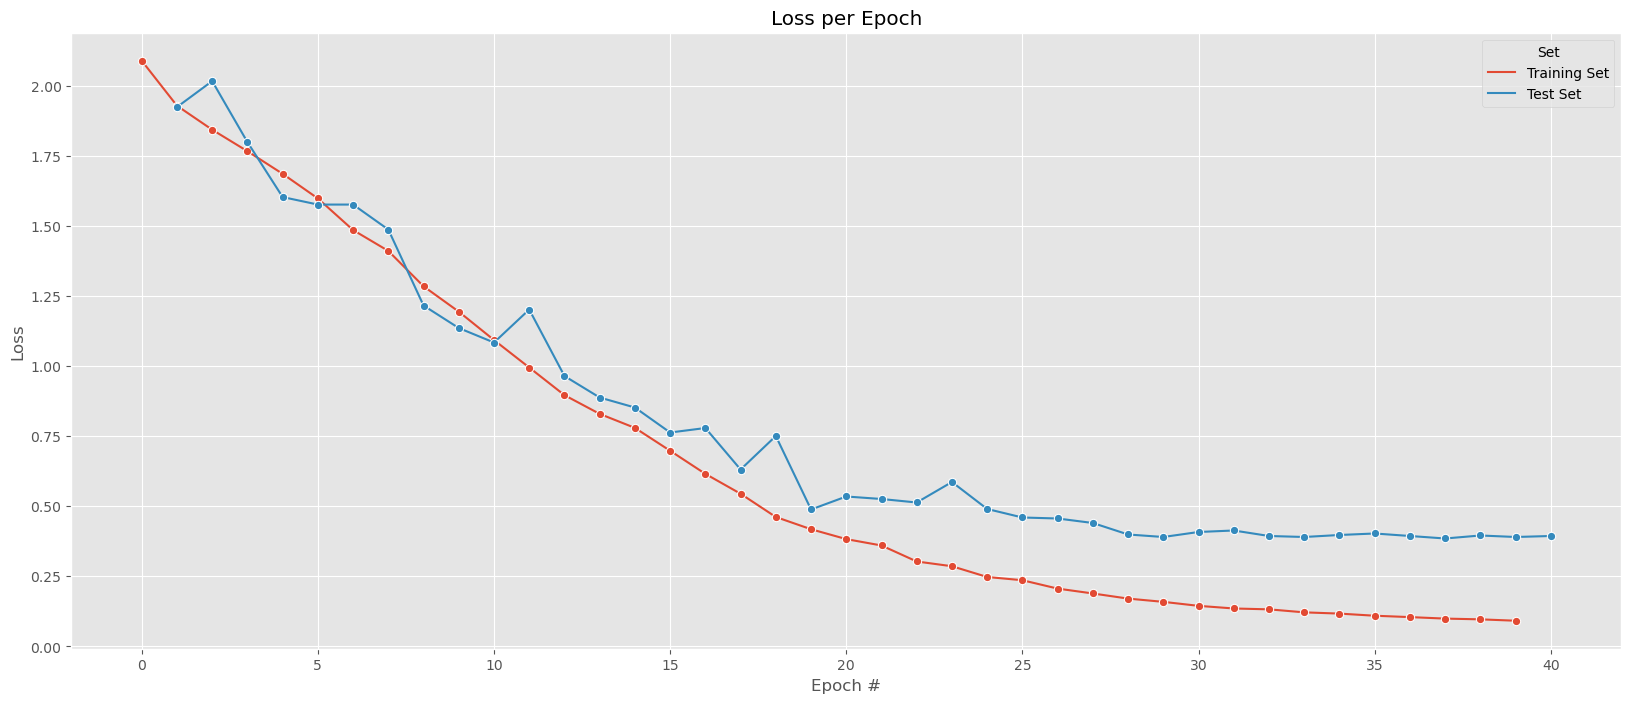

In [38]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Set', marker='o')
ax.set(title="Loss per Epoch", xlabel="Epoch #", ylabel="Loss")

plt.show()

# Error Analysis

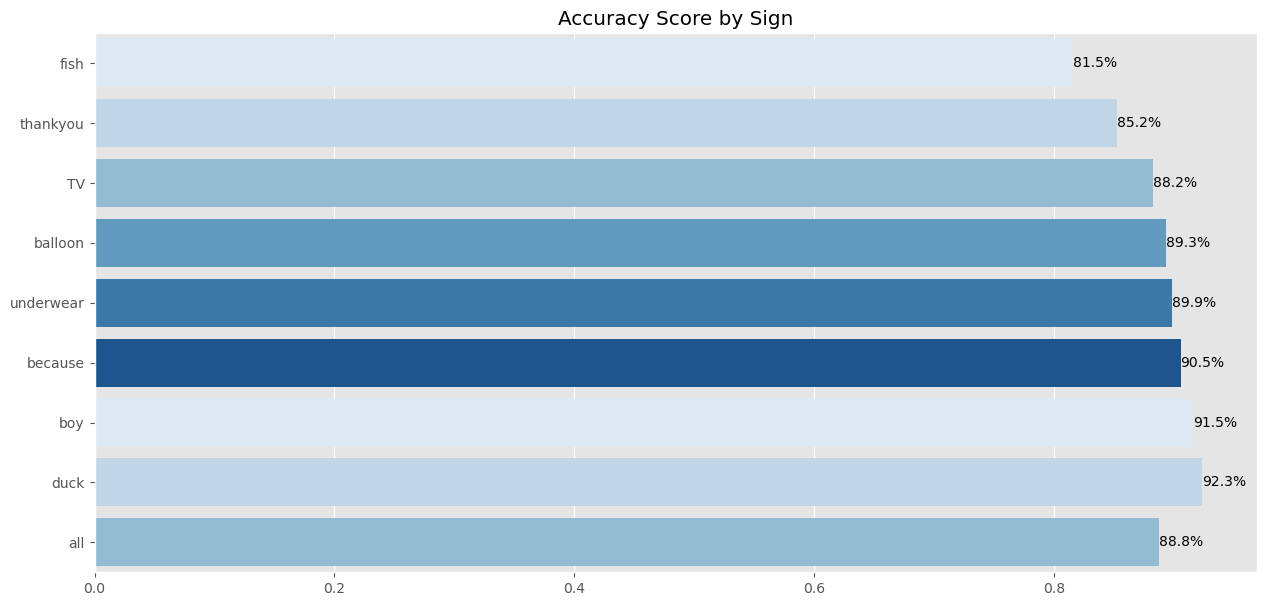

In [39]:
test_set.loc[:, 'prediction'] = guesses

accuracy_scores = (pd.DataFrame(pd.concat([
    test_set.groupby('sign').apply(lambda x: accuracy_score(x.sign, x.prediction)).sort_values(),
    pd.Series({'all': accuracy_score(test_set.sign, test_set.prediction)})
]))
 .reset_index()
 .rename(columns={'index': 'Sign', 0: 'Accuracy'})
)
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.barplot(data=accuracy_scores, y='Sign', x='Accuracy', ax=ax, palette=sns.color_palette('Blues'))
ax.set(title='Accuracy Score by Sign', xlabel='', ylabel='')

for i in ax.containers:
    ax.bar_label(i, [f'{j:.1%}' for j in i.datavalues])

plt.show()

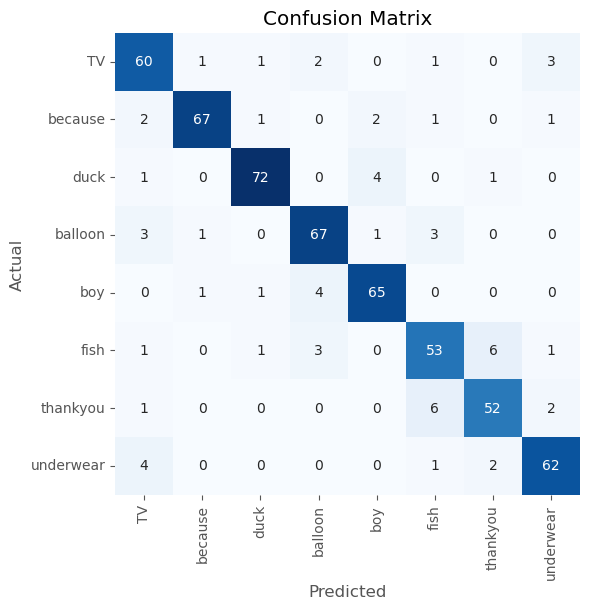

In [40]:
cf_matrix = confusion_matrix(test_set.sign, test_set.prediction, labels=signs_subset)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, ax=ax,
            xticklabels=signs_subset, yticklabels=signs_subset)
ax.set(title="Confusion Matrix", xlabel="Predicted", ylabel="Actual")

plt.show()

In [17]:
test_error_mask = test_set.sign != test_set.prediction
cols = ['sign', 'prediction', 'total_frames', 'left_hand', 'right_hand']
test_errors = test_set.loc[test_error_mask, cols]
test_errors

,sign,prediction,total_frames,left_hand,right_hand
idx,,,,,
4718_1468852886,because,TV,112.0,0.0,58.0
61333_3563388072,duck,TV,10.0,2.0,0.0
37055_1713148661,duck,TV,26.0,4.0,0.0
4718_3674579755,TV,duck,133.0,0.0,101.0
25571_1414019015,duck,TV,81.0,78.0,0.0
16069_226936067,because,TV,16.0,10.0,0.0
36257_3253558482,duck,TV,42.0,17.0,0.0
29302_2205883533,duck,because,105.0,0.0,33.0
25571_619010081,duck,TV,12.0,0.0,4.0


# Follow Ups

* **62590_2830028337** (TV) gets flipped upside down when we make x and y negative
* **61333_160738324** (because) has only one single frame with a hand in it
* **61333_160738324** (TV) has 103 frames (avg. frames for TV is 23) and keeps the pointer finger up the whole time
* **29302_3511736219** (because) is generally pretty good data - maybe the sign takes too long?